# Digit Recognizer
For task 2, I chose to use the [MNIST](https://www.kaggle.com/c/digit-recognizer/data?select=train.csv) dataset, a dataset of about 42000 images which represent handwritten digits. The goal is to train a model that would be able to classify each image as a digit. Herein, I use several classification techniques to achieve this. I felt that this was an appropriate dataset as it does not require an intense amount of computational power to train a model which could describe the data. Yet, it is an interesting problem that can be solved a number of different ways. 

The notebook is split into the following sections:
- Description of the dataset (EDA)
- Models
- Further Work

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('digit.csv')

Let us first look at the distribution of the dataset with respect to its classes.

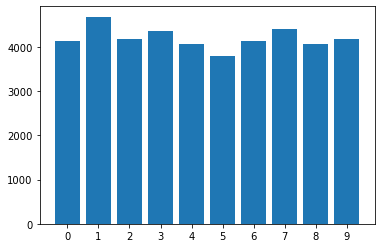

In [3]:
v = dict(df.label.value_counts())
plt.xticks([i for i in range (10)])
plt.bar(v.keys(), v.values())
plt.show()

We see that the classes are well distributed. This suggests that we may not need to particularly weight the classes. Note that if the distribution was extremely skewed, we may need to weight the data points, inverse to their frequency in the dataset. 

Now, let us examine the variance between data points in the same class. In other words, are there rotational transformatins, reflections, etc. We do a preliminary examination by simply superimposing all images of the same class on top of each other. 

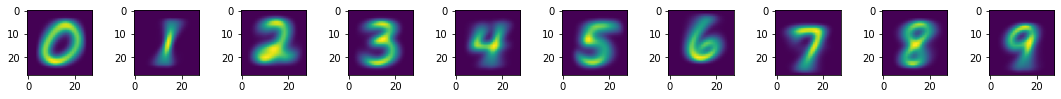

In [4]:
f, axes = plt.subplots(1,10,figsize=(15,20))
f.tight_layout()
for i in range(10):
    digit = df[df.label==i]
    img = digit.iloc[:,1:].mean()
    axes[i].imshow(img.values.reshape((28,28)))
plt.show()

For any given image, we performed superimposition by simply averaging all of these images together. This would allow us to see what the general characteristic of each digit in the dataset looks like, which may help us later on when constructing our model.

We see that there is some variance between images of the same class. However, the highlights on the image make clear that there are characteristic invariants; for example, the rigid angle in the 7, or the curve on the 2 are clearly define across almost all images. We do see that the 4 and 5 have faded edges which likely means there is more variation there. This may be something that we need to watch out for when we draw the final confusion matrix (i.e. a place where our models may make significant errors).

We now look at some sample images in each class to get a better picture of what is going on.

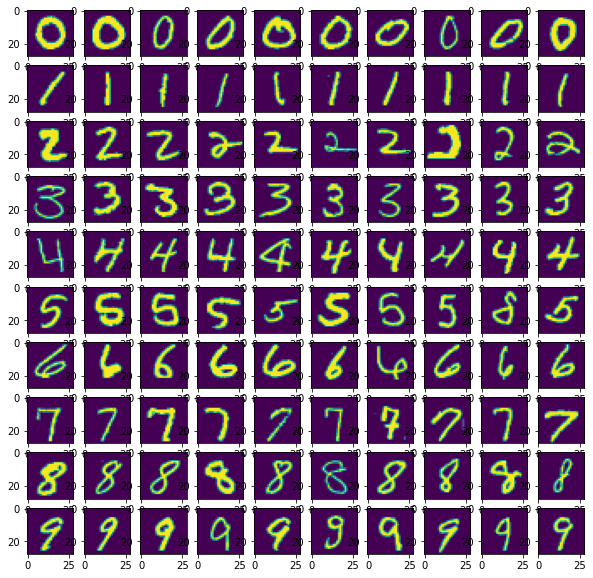

In [5]:
f,axes = plt.subplots(10,10, figsize=(10,10))
for i in range(10):
    digit = df[df.label==i]
    for j in range(10):
        img = digit.iloc[j,1:]
        axes[i,j].imshow(img.values.reshape((28,28)))

Again, there seems to be little rotational and scaling variance. This may allow for more simplistic techniques such as a Naive Bayes or a logsitic regression. We start with these techniques, then work up to a convolutional neural network.

## Models
- Naive Bayes 
- Logsitic Regression
- Convolutional Neural Network

We first split the data into the training and test set.

In [6]:
X, Y = df.iloc[:,1:].to_numpy(), df.iloc[:,0]
Xs = np.ceil(X)
xtrain, xtest, ytrain, ytest = train_test_split(Xs,Y,test_size=0.2)

### Naive Bayes
We start with a simply probabilistic model. This will give us a baseline from which we can improve upon. 

A naive bayes model is based on Bayes' rule:
$$P(H|e) = \frac{P(e|H)\cdot P(H)}{P(e)},$$
or in other words,
$$\text{posterior} \propto \text{likelihood}\cdot \text{prior}.$$
$e$ is the evidence (or data), while $H$ is the hypothesis (or class). Herein, we assume a Bernoulli distribution for our data as each pixel can be turned on or off (representing a binary decision). We also saw in the previous subsection that there was little variance between pictures in the same class; therefore, this simplication may help the model learn better. 

In [7]:
bnb = BernoulliNB()
bnb.fit(xtrain,ytrain)
ptest = bnb.predict(xtest)
print(f"Test Accuracy: {accuracy_score(ytest, ptest)}")

Test Accuracy: 0.8322619047619048


Note that I am reporting the accuracy because of the class balance. If it were imbalanced we would prefer macro F1 or some other metric. Now, let us see the confusion matrix of Naive Bayes on the test set. 

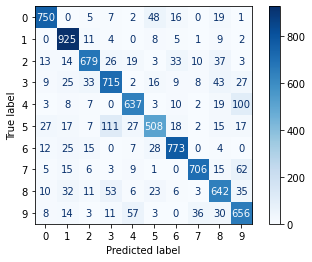

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, ptest))
disp.plot(cmap='Blues')
plt.show()

We saw that the Naive Bayes classifier did pretty well. 

Based on the confusion matrix, we see that it got primarily confused discriminating the 4 from 5 (as described in the previous section *this may be a significant point of confusion*), and the 9 from 4. 

We may improve this model by attacking the Naive assumption. That is, the NB classifier assumes all of the features are independent to use the product rule:
$$
\begin{align}
P(y|x_1,\ldots,x_n) &\propto P(x_1,\ldots,x_n|y)\cdot P(y), \tag{Bayes' rule}\\
&\propto P(y)\prod_{i=1}^n P(x_i|y), \tag{indepdence of features assumption}\\
&\propto \log(P(y)) + \sum_{i=1}^n\log(P(x_i|y)).
\end{align}
$$

However, intuitively, we know the pixels are definitely not completely independent. Therefore, we may use another approach that does not make this assumption. This motivates the use of a geometric classifier: logisitic regression.

### Logistic Regression
A logisitic regression is a geometric classifier in that it tries to approximate the step function that describes the relationship between the data and its classes. I thought that this may improve upon the Naive Bayes' classifier because it does not make the Naive assumption. 

In [9]:
X = X/255
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2)
lr = LogisticRegression(max_iter=1000)
lr.fit(xtrain,ytrain)

LogisticRegression(max_iter=1000)

In [10]:
ptest = lr.predict(xtest)
print(f"Test Accuracy: {lr.score(xtest,ytest)}")

Test Accuracy: 0.9148809523809524


We do see that the logistic regression is a significant improvement over the Naive Bayes' classifier. 

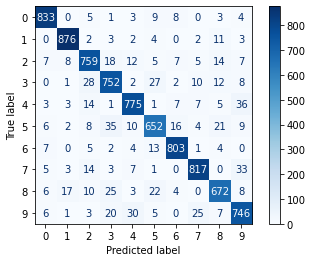

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, ptest))
disp.plot(cmap='Blues')
plt.show()

A logisitic regression assumes that the relationship between the features are linearly (that there exists some linearity must exist). This may not be true, and we may try to visualize this by projecting the dataset onto some 3D space. Therefore, we could try non-linear methods such as clustering. However, we want to use the given labels to our advantage. Hence, in the next section we try CNNs, the hallmark of modern computer vision.

### Convolutional Neural Network
A convolutional neural network is great for computer vision because it is able to "extract" lines, edges, and more abstract features out from the image. Therefore, our neural architecture is predicated on some early convolutional layers which provide this feature extraction capability. Then, we "interpret" these features using a bunch of linear layers.

In [12]:
import torch
import pytorch_lightning as pl
from torch.optim import Adam,SGD
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms

Define some basic transformations that would allow our data to be passed into Torch. Since each feature in the data given to us is in the interval [0,255] we also perform some normalization.

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [14]:
# Define training dataset
# 
# Note that we are defining the training and testing dataset separately because we may want to 
# introduce test-time augmentations into the test set to achieve greater accuracy. 
class MNIST(Dataset):
    def __init__(self, X, Y, transform):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Augmentations
        img = np.reshape(self.X[idx,:], (28,28))
        if self.transform is not None:
            return self.transform(img), self.Y.iloc[idx]
        return torch.Tensor(img), self.Y.iloc[idx]

I've never really used torch on CPU (only GPU) before, and found that for some reason it strictly enforces the use of a double. Therefore, we convert the training data into double first as well as the model later on.

In [26]:
X, Y = df.iloc[:,1:].to_numpy(), df.iloc[:,0]
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2)
xtrain = xtrain.astype(np.float64)

In [27]:
# Create datasets and dataloaders
xval, yval = xtrain[:int(len(xtrain) * 0.1)], ytrain[:int(len(xtrain) * 0.1)]
xt, yt = xtrain[int(len(xtrain) * 0.1):], ytrain[int(len(xtrain) * 0.1):]
train = MNIST(xt,yt,transform)
val = MNIST(xval,yval,transform)

train_loader = DataLoader(train,batch_size=32)
val_loader = DataLoader(val,batch_size=32)

Since we are really limited by computational power, I will train a relatively shallow neural network with two convolutional feature extractors, then some linear interpolation layers. Note that I could have also used transfer learning: 

Simply just taking a high performing model trained on ImageNet, then retrained its linear layers for this particular task. I could have also "un-frozen" the first few layers and then trained part of the feature extractor as well.

In [28]:
# Model
class LinModel(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-9,optim=Adam,loss=nn.CrossEntropyLoss()):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.optim = optim
        self.lf = loss
        # Wide then narrow – feature extraction architecture
        self.convlayers = nn.ModuleList([
            nn.Conv2d(1,32,3),
            nn.ReLU(),
            nn.Conv2d(32,64,2),
            nn.ReLU(),
            nn.MaxPool2d(5)
        ]).double()
        self.linlayers = nn.ModuleList([
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256,10),
            nn.Softmax(dim=0)
        ]).double()

    def forward(self,x):
        out = x
        for layer in self.convlayers:
            out = layer(out)
        out = out.flatten(start_dim=1)
        for layer in self.linlayers:
            out = layer(out)
        return out
    
    def step(self, batch, batch_idx):
        """
        One "step" of the model. 
        """
        x,y = batch
        predictions = self(x)
        loss = self.loss(predictions, y)
        return loss, {'loss': loss,'acc':self.accuracy(predictions,y)}
    
    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f'train_{k}': v for k, v in logs.items()},
                      on_step=True, on_epoch=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f'val_{k}': v for k, v in logs.items()}, sync_dist=True)
        return loss
    
    def loss(self,prediction,label):
        return self.lf(prediction,label)
    
    def accuracy(self,prediction,label):
        g = torch.argmax(prediction,dim=1)
        return accuracy_score(g,label)
    
    def configure_optimizers(self):
        return (self.optim(self.parameters(), lr=self.lr, weight_decay=self.weight_decay))
    

In [31]:
# Training
model = LinModel(lr=1e-5,weight_decay=1e-9,optim=Adam)
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_loader,val_loader)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type             | Params
------------------------------------------------
0 | lf         | CrossEntropyLoss | 0     
1 | convlayers | ModuleList       | 8.6 K 
2 | linlayers  | ModuleList       | 264 K 
------------------------------------------------
273 K     Trainable params
0         Non-trainable params
273 K     Total params
1.094     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
model(torch.Tensor(xtest[0].reshape((1,28,28)) / 255))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 3, 3], but got 3-dimensional input of size [1, 28, 28] instead

After some preliminary tuning, I found that these hyperparameters worked best.

## Some More Ideas...
If time and computational power would allow here are some more ideas that I would've tried:
- Clustering
- Transfer learning with a high performing ImageNet model
    - Though not as exciting, we could experiment with various feature extractors here to see which one would work best (probably ResNet though...)
    - UnFreeze the last few layers of the feature extractors for fine tuning.
- Vision transformers
    - I've used transformers for language modeling before, and I've heard about transformers now being generalizable to vision tasks. This is a really cool concept and something that would be interesting to see here. 
- Test-time augmentation
    - For a given test image, transform it many ways (rotation, scaling, etc.) Then, run the model over all these transformed images. The resulting class is found through a majority vote. 
    - This is a technique I've used often during competitions to increase predictive accuracy. Though it may not be too applicable here because the dataset itself is low variance. 
- Ensembling
    - Also another really cheeky technique that I've picked up for Kaggle competitions: training a bunch of models that are "fundamentally" different. 
    - For a given test image, we run this test image through all of the models. Then, we interpolate the final decision based on a weighted majority vote according to classification strength and model correlation (the more model correlation, the less weight we would give each of these models). 
    - This technique is really cool because it embodies the idea that "the sum of the whole is greater than the sum of its individual parts," (i.e. different models make up for each other if the distribution of their errors is different enough).